# Face Alignment Preprocessor for Selfie Timelapse

This notebook preprocesses selfie images by aligning faces based on eye positions to create consistent face timelapses. The process involves detecting faces, extracting eye landmarks, and applying geometric transformations to align all faces uniformly.

## 1. Import Required Libraries

Import necessary libraries including OpenCV, dlib, NumPy, PIL, and os for image processing and face detection.

In [15]:
# --- INSTALL ALL REQUIRED PACKAGES ---
# This line checks if the packages are installed and installs them if they are not.
# It's a good practice to run this line in a new notebook to ensure a consistent environment.
!pip install https://github.com/omwaman1/dlib_wheel_for_python/releases/download/dlib-python3.13.5/dlib-20.0.0-cp313-cp313-win_amd64.whl opencv-python numpy matplotlib

# --- IMPORT ALL REQUIRED PACKAGES ---
import dlib
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from pathlib import Path

     ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
     --- ------------------------------------ 0.3/2.9 MB ? eta -:--:--
     ---------------------------------------- 2.9/2.9 MB 11.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Set Up Directory Paths

Define input and output directory paths, create output directory if it doesn't exist.

In [16]:
# Define directory paths
base_dir = Path.cwd()
source_dir = base_dir / "source_selfies" / "test_selfies"
output_dir = base_dir / "output_selfies" / "test_selfies"

# Create output directory if it doesn't exist
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Source directory: {source_dir}")
print(f"Output directory: {output_dir}")
print(f"Source directory exists: {source_dir.exists()}")
print(f"Output directory exists: {output_dir.exists()}")

Source directory: c:\Users\Chimeng62\Desktop\daily_selfie_preporcessor_notebook\source_selfies\test_selfies
Output directory: c:\Users\Chimeng62\Desktop\daily_selfie_preporcessor_notebook\output_selfies\test_selfies
Source directory exists: True
Output directory exists: True


## 3. Load and Display Test Images

Load test images from the source_selfies/test_selfies folder and display them to verify the input data.

In [17]:
# Get list of image files
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
image_files = []

for ext in image_extensions:
    image_files.extend(list(source_dir.glob(f'*{ext}')))
    image_files.extend(list(source_dir.glob(f'*{ext.upper()}')))

image_files.sort()

print(f"Found {len(image_files)} images:")
for i, img_path in enumerate(image_files[:5]):  # Show first 5 files
    print(f"{i+1}. {img_path.name}")

if len(image_files) > 5:
    print(f"... and {len(image_files) - 5} more")

Found 48 images:
1. IMG_20230102_203909.jpg
2. IMG_20230102_203909.jpg
3. IMG_20230104_142640.jpg
4. IMG_20230104_142640.jpg
5. IMG_20230105_144723.jpg
... and 43 more


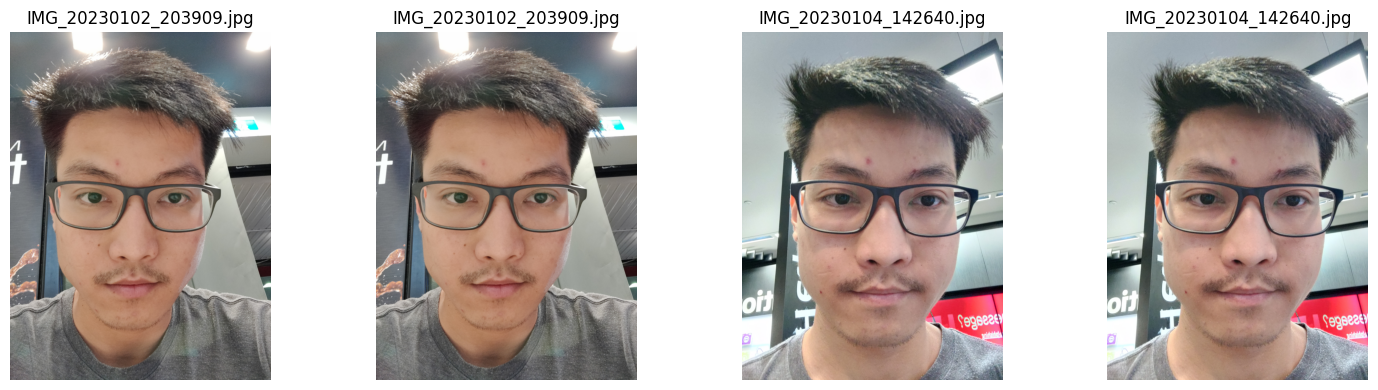

In [18]:
# Display first few images
def display_images(image_paths, max_images=4):
    fig, axes = plt.subplots(1, min(len(image_paths), max_images), figsize=(15, 4))
    if min(len(image_paths), max_images) == 1:
        axes = [axes]
    
    for i, img_path in enumerate(image_paths[:max_images]):
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        axes[i].set_title(img_path.name)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

if image_files:
    display_images(image_files[:4])
else:
    print("No images found in the source directory!")

## 4. Test dlib Functionality

Test if dlib is working properly and can detect faces and facial landmarks. This is crucial for the facial alignment pipeline.

=== TESTING DLIB FUNCTIONALITY ===
✅ dlib imported successfully
✅ dlib face detector initialized successfully
✅ dlib facial landmark predictor loaded successfully
   Using model: shape_predictor_68_face_landmarks.dat

🧪 Testing face detection on: IMG_20230102_203909.jpg
   Detected 1 face(s)
✅ Face detection working!
✅ Landmark detection working! Found 68 landmarks


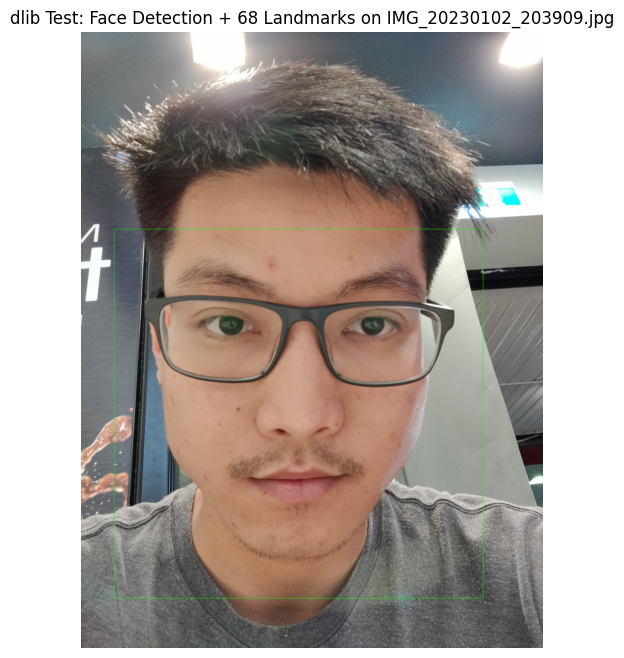

🎉 dlib is fully functional!
   Ready for facial alignment pipeline

📊 DLIB STATUS: ✅ READY


In [21]:
# Test dlib functionality
print("=== TESTING DLIB FUNCTIONALITY ===")

# Check if dlib is available
try:
    import dlib
    DLIB_AVAILABLE = True
    print("✅ dlib imported successfully")
except ImportError:
    DLIB_AVAILABLE = False
    print("❌ dlib not available")

# Initialize face detector
if DLIB_AVAILABLE:
    try:
        face_detector = dlib.get_frontal_face_detector()
        print("✅ dlib face detector initialized successfully")
        
        # Test landmark predictor
        predictor_path = "shape_predictor_68_face_landmarks.dat"
        predictor = None
        
        if os.path.exists(predictor_path):
            try:
                predictor = dlib.shape_predictor(predictor_path)
                print("✅ dlib facial landmark predictor loaded successfully")
                print(f"   Using model: {predictor_path}")
            except Exception as e:
                print(f"❌ Failed to load landmark predictor: {str(e)}")
        else:
            print("⚠️  Landmark predictor file not found!")
            print(f"   Expected location: {predictor_path}")
            print("   Download from: http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2")
            print("   Or download a prebuilt version and place it in the notebook directory")
        
        # Test face detection on first image if available
        if image_files:
            test_image_path = image_files[0]
            print(f"\n🧪 Testing face detection on: {test_image_path.name}")
            
            test_image = cv2.imread(str(test_image_path))
            test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
            
            # Detect faces
            faces = face_detector(test_image_gray)
            print(f"   Detected {len(faces)} face(s)")
            
            if len(faces) > 0:
                print("✅ Face detection working!")
                
                # Test landmark detection if predictor is available
                if predictor is not None:
                    face = faces[0]  # Use first detected face
                    landmarks = predictor(test_image_gray, face)
                    print(f"✅ Landmark detection working! Found {landmarks.num_parts} landmarks")
                    
                    # Visualize the results
                    test_image_vis = test_image.copy()
                    
                    # Draw face rectangle
                    x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
                    cv2.rectangle(test_image_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    
                    # Draw landmarks
                    for i in range(landmarks.num_parts):
                        x = landmarks.part(i).x
                        y = landmarks.part(i).y
                        cv2.circle(test_image_vis, (x, y), 2, (0, 0, 255), -1)
                    
                    # Display result
                    plt.figure(figsize=(12, 8))
                    plt.imshow(cv2.cvtColor(test_image_vis, cv2.COLOR_BGR2RGB))
                    plt.title(f"dlib Test: Face Detection + 68 Landmarks on {test_image_path.name}")
                    plt.axis('off')
                    plt.show()
                    
                    print("🎉 dlib is fully functional!")
                    print("   Ready for facial alignment pipeline")
                else:
                    print("⚠️  Landmark detection unavailable - need shape_predictor_68_face_landmarks.dat")
            else:
                print("⚠️  No faces detected - try with a clearer selfie image")
        else:
            print("⚠️  No test images available")
            
    except Exception as e:
        print(f"❌ dlib face detector initialization failed: {str(e)}")
        DLIB_AVAILABLE = False
else:
    print("❌ dlib not available")
    print("   The advanced facial alignment pipeline requires dlib")
    print("   Please install dlib or use the basic OpenCV fallback")

print(f"\n📊 DLIB STATUS: {'✅ READY' if DLIB_AVAILABLE and 'predictor' in locals() and predictor is not None else '❌ NOT READY'}")

## 5. Face Detection

For each image, detect the face and isolate the region of interest for facial landmark detection.

=== STEP 5: FACE DETECTION ===
Processing 48 images for face detection...


Detecting faces: 100%|██████████| 48/48 [01:15<00:00,  1.58s/it]



📊 Face Detection Results:
✅ Successfully detected faces: 48/48
❌ Failed detections: 0

🖼️  Showing face detection on first 3 images:


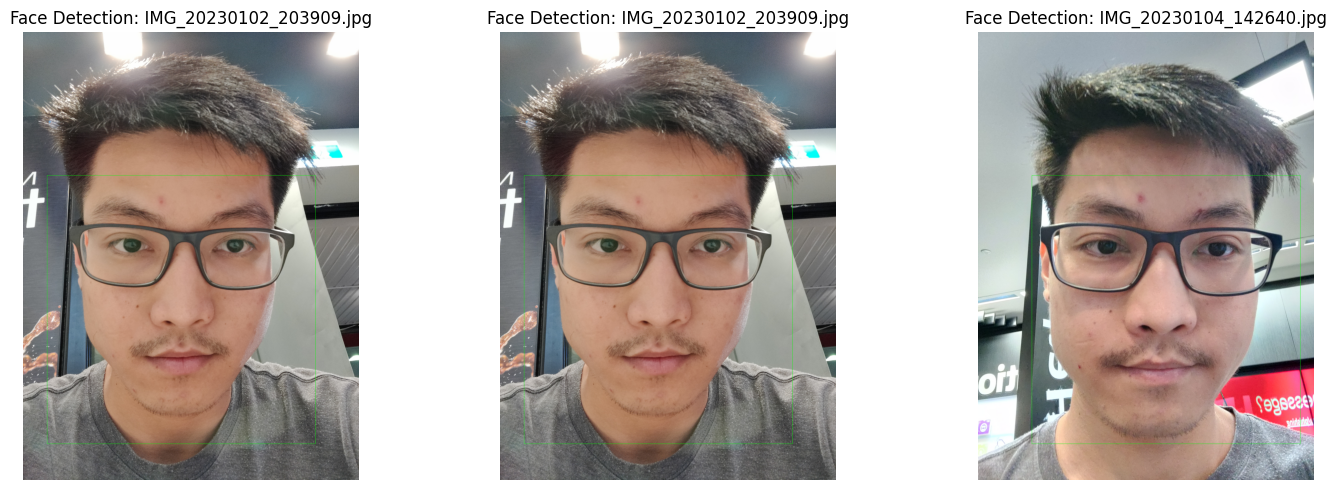

✅ Face detection completed successfully!
   Ready for landmark detection in next step


In [22]:
# Face Detection on all images
print("=== STEP 5: FACE DETECTION ===")

# Import tqdm for progress tracking
try:
    from tqdm import tqdm
except ImportError:
    # Fallback if tqdm not available
    def tqdm(iterable, desc="Processing"):
        print(f"{desc}...")
        return iterable

def detect_face_in_image(image_path):
    """
    Detect face in a single image.
    
    Args:
        image_path: Path to the image
    
    Returns:
        tuple: (image, gray_image, face_rect) or None if no face detected
    """
    try:
        image = cv2.imread(str(image_path))
        if image is None:
            return None
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_detector(gray)
        
        if len(faces) == 0:
            return None
        
        # Use the largest face if multiple faces detected
        largest_face = max(faces, key=lambda f: f.width() * f.height())
        
        return image, gray, largest_face
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

# Process all images for face detection
if 'DLIB_AVAILABLE' in locals() and DLIB_AVAILABLE and image_files:
    print(f"Processing {len(image_files)} images for face detection...")
    
    face_data = []
    failed_images = []
    
    for img_path in tqdm(image_files, desc="Detecting faces"):
        result = detect_face_in_image(img_path)
        if result is not None:
            image, gray, face_rect = result
            face_data.append({
                'path': img_path,
                'image': image,
                'gray': gray,
                'face': face_rect,
                'name': img_path.name
            })
        else:
            failed_images.append(img_path.name)
    
    print(f"\n📊 Face Detection Results:")
    print(f"✅ Successfully detected faces: {len(face_data)}/{len(image_files)}")
    print(f"❌ Failed detections: {len(failed_images)}")
    
    if failed_images:
        print(f"\nFailed images:")
        for name in failed_images[:5]:  # Show first 5
            print(f"  - {name}")
        if len(failed_images) > 5:
            print(f"  ... and {len(failed_images) - 5} more")
    
    # Visualize face detection results on a few samples
    if len(face_data) >= 3:
        print(f"\n🖼️  Showing face detection on first 3 images:")
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        for i in range(3):
            data = face_data[i]
            img_vis = data['image'].copy()
            face = data['face']
            
            # Draw face rectangle
            x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
            cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            axes[i].imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
            axes[i].set_title(f"Face Detection: {data['name']}")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Face detection completed successfully!")
        print("   Ready for landmark detection in next step")
    else:
        print("⚠️  Need at least 3 successful face detections to proceed")
        
else:
    print("❌ Cannot proceed: dlib not available or no images found")
    print("   Please ensure dlib is working and images are loaded")

## 6. Facial Landmark Detection

Within each detected face, identify key facial landmarks such as eyes, nose, and mouth corners. These landmarks will be used to calculate the average face geometry.

=== STEP 6: FACIAL LANDMARK DETECTION ===
Extracting landmarks from 48 faces...


Extracting landmarks: 100%|██████████| 48/48 [00:00<00:00, 380.94it/s]


📊 Landmark Detection Results:
✅ Successfully extracted landmarks: 48/48
❌ Failed extractions: 0

🎯 Showing landmarks on first 3 images:


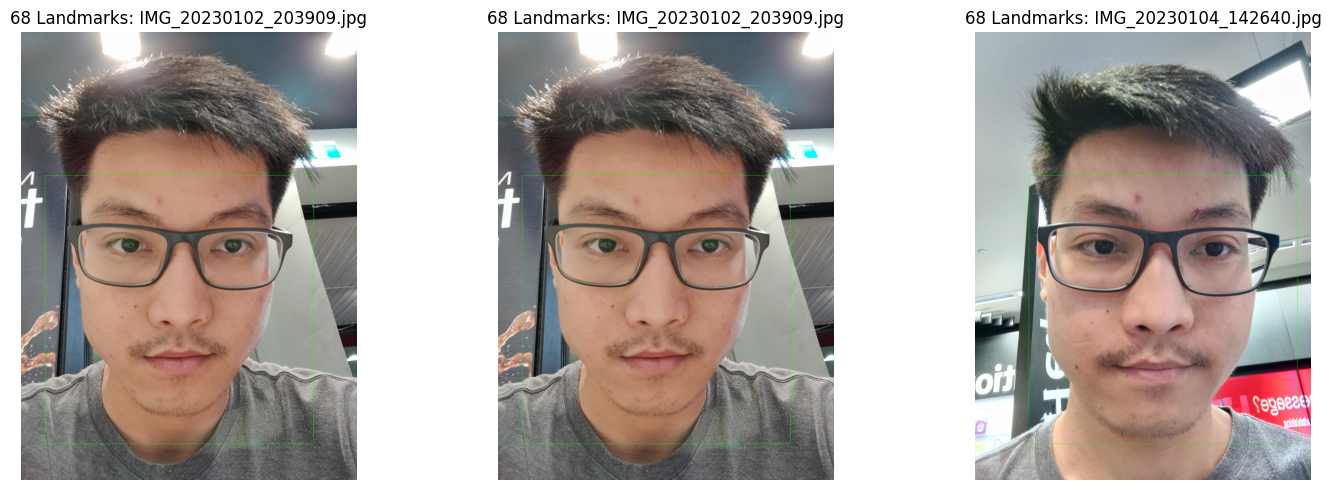


📈 Landmark Statistics:
   Total faces with landmarks: 48
   Landmarks per face: 68
   Landmark array shape: (48, 68, 2)
   Ready for average face calculation!


In [23]:
# Facial Landmark Detection
print("=== STEP 6: FACIAL LANDMARK DETECTION ===")

def extract_landmarks(gray_image, face_rect, predictor):
    """
    Extract 68 facial landmarks from a face.
    
    Args:
        gray_image: Grayscale image
        face_rect: Face rectangle from dlib
        predictor: dlib landmark predictor
    
    Returns:
        numpy array of shape (68, 2) with landmark coordinates
    """
    landmarks = predictor(gray_image, face_rect)
    points = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(68)])
    return points

# Extract landmarks from all detected faces
if ('DLIB_AVAILABLE' in locals() and DLIB_AVAILABLE and 
    'predictor' in locals() and predictor is not None and 
    'face_data' in locals()):
    print(f"Extracting landmarks from {len(face_data)} faces...")
    
    landmark_data = []
    failed_landmarks = []
    
    for data in tqdm(face_data, desc="Extracting landmarks"):
        try:
            landmarks = extract_landmarks(data['gray'], data['face'], predictor)
            landmark_data.append({
                'path': data['path'],
                'name': data['name'],
                'image': data['image'],
                'landmarks': landmarks,
                'face': data['face']
            })
        except Exception as e:
            failed_landmarks.append(data['name'])
            print(f"Failed to extract landmarks from {data['name']}: {str(e)}")
    
    print(f"\n📊 Landmark Detection Results:")
    print(f"✅ Successfully extracted landmarks: {len(landmark_data)}/{len(face_data)}")
    print(f"❌ Failed extractions: {len(failed_landmarks)}")
    
    if landmark_data:
        # Visualize landmarks on a few samples
        print(f"\n🎯 Showing landmarks on first 3 images:")
        
        fig, axes = plt.subplots(1, min(3, len(landmark_data)), figsize=(15, 5))
        if len(landmark_data) == 1:
            axes = [axes]
        
        for i in range(min(3, len(landmark_data))):
            data = landmark_data[i]
            img_vis = data['image'].copy()
            landmarks = data['landmarks']
            
            # Draw face rectangle
            face = data['face']
            x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
            cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Draw all 68 landmarks
            for (x, y) in landmarks:
                cv2.circle(img_vis, (int(x), int(y)), 2, (0, 0, 255), -1)
            
            # Highlight key points (eyes, nose tip, mouth corners)
            key_points = [36, 39, 42, 45, 30, 48, 54]  # Left eye, right eye, nose tip, mouth corners
            for idx in key_points:
                x, y = landmarks[idx]
                cv2.circle(img_vis, (int(x), int(y)), 4, (255, 255, 0), -1)
            
            axes[i].imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
            axes[i].set_title(f"68 Landmarks: {data['name']}")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Show landmark statistics
        all_landmarks = np.array([data['landmarks'] for data in landmark_data])
        print(f"\n📈 Landmark Statistics:")
        print(f"   Total faces with landmarks: {len(landmark_data)}")
        print(f"   Landmarks per face: 68")
        print(f"   Landmark array shape: {all_landmarks.shape}")
        print(f"   Ready for average face calculation!")
        
    else:
        print("❌ No landmarks extracted - cannot proceed with alignment")
        
else:
    print("❌ Cannot proceed: Missing predictor, dlib, or face data")
    print("   Please ensure previous steps completed successfully")

## 7. Calculate the "Average Face"

Calculate the average position for each landmark across all images. This creates a stable, consistent target geometry that represents the entire collection and will be used for alignment.

=== STEP 7: CALCULATE THE AVERAGE FACE ===
Calculating average from 48 faces...
Landmark array shape: (48, 68, 2)
Average landmarks shape: (68, 2)

📊 Average Face Statistics:
   Mean standard deviation X: 94.35 pixels
   Mean standard deviation Y: 219.29 pixels
   Total variance: 156.82 pixels

🎭 Visualizing the Average Face:


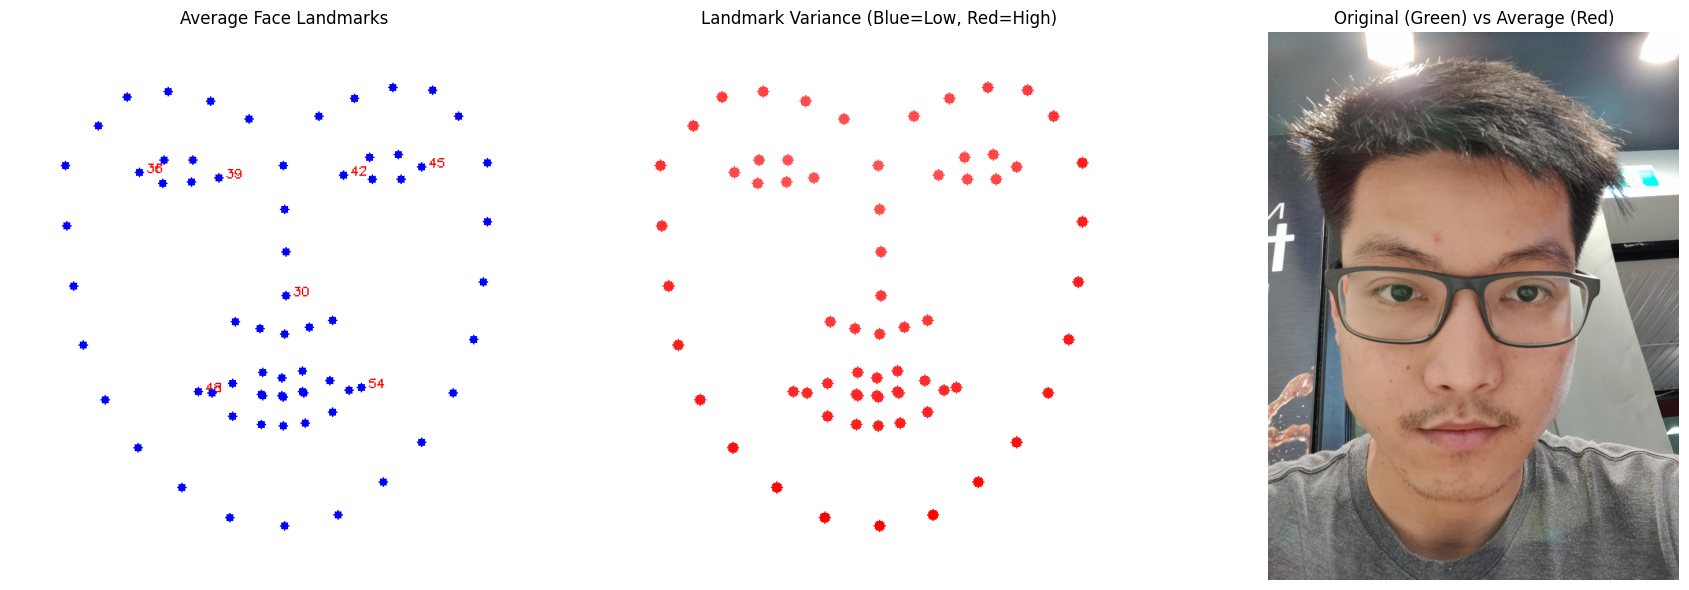


✅ Average face calculated successfully!
   Average landmarks ready for alignment step
   This will be the target geometry for all face alignments


In [24]:
# Calculate the Average Face
print("=== STEP 7: CALCULATE THE AVERAGE FACE ===")

if 'landmark_data' in locals() and len(landmark_data) > 0:
    # Collect all landmarks
    all_landmarks = np.array([data['landmarks'] for data in landmark_data])
    print(f"Calculating average from {len(landmark_data)} faces...")
    print(f"Landmark array shape: {all_landmarks.shape}")
    
    # Calculate mean landmarks
    average_landmarks = np.mean(all_landmarks, axis=0)
    print(f"Average landmarks shape: {average_landmarks.shape}")
    
    # Calculate standard deviation to understand variance
    landmark_std = np.std(all_landmarks, axis=0)
    
    # Calculate some statistics
    mean_std_x = np.mean(landmark_std[:, 0])
    mean_std_y = np.mean(landmark_std[:, 1])
    
    print(f"\n📊 Average Face Statistics:")
    print(f"   Mean standard deviation X: {mean_std_x:.2f} pixels")
    print(f"   Mean standard deviation Y: {mean_std_y:.2f} pixels")
    print(f"   Total variance: {np.mean(landmark_std):.2f} pixels")
    
    # Visualize the average face
    print(f"\n🎭 Visualizing the Average Face:")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Show average landmarks on a blank canvas
    canvas_size = 400
    canvas = np.ones((canvas_size, canvas_size, 3), dtype=np.uint8) * 255
    
    # Scale and center the average landmarks to fit the canvas
    landmarks_scaled = average_landmarks.copy()
    landmarks_scaled = landmarks_scaled - np.min(landmarks_scaled, axis=0)  # Move to origin
    landmarks_scaled = landmarks_scaled / np.max(landmarks_scaled) * (canvas_size * 0.8)  # Scale to fit
    landmarks_scaled = landmarks_scaled + (canvas_size * 0.1)  # Add padding
    
    # Draw the average face landmarks
    for i, (x, y) in enumerate(landmarks_scaled):
        cv2.circle(canvas, (int(x), int(y)), 3, (255, 0, 0), -1)
        # Add numbers for key landmarks
        if i in [36, 39, 42, 45, 30, 48, 54]:  # Key points
            cv2.putText(canvas, str(i), (int(x)+5, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
    
    axes[0].imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Average Face Landmarks")
    axes[0].axis('off')
    
    # 2. Show variance visualization (heatmap of standard deviation)
    variance_canvas = np.ones((canvas_size, canvas_size, 3), dtype=np.uint8) * 255
    
    # Color-code landmarks by their variance
    max_var = np.max(landmark_std)
    for i, ((x, y), (std_x, std_y)) in enumerate(zip(landmarks_scaled, landmark_std)):
        variance = np.sqrt(std_x**2 + std_y**2)
        intensity = int(255 * (1 - variance / max_var))  # Higher variance = redder
        color = (intensity, intensity, 255)  # Blue to red gradient
        cv2.circle(variance_canvas, (int(x), int(y)), 4, color, -1)
    
    axes[1].imshow(cv2.cvtColor(variance_canvas, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Landmark Variance (Blue=Low, Red=High)")
    axes[1].axis('off')
    
    # 3. Show overlay of first image with average landmarks
    if len(landmark_data) > 0:
        first_image = landmark_data[0]['image'].copy()
        first_landmarks = landmark_data[0]['landmarks']
        
        # Draw original landmarks in green
        for (x, y) in first_landmarks:
            cv2.circle(first_image, (int(x), int(y)), 2, (0, 255, 0), -1)
        
        # Draw average landmarks in red (scaled to match first image)
        # Simple scaling based on face size
        face = landmark_data[0]['face']
        face_width = face.right() - face.left()
        face_height = face.bottom() - face.top()
        
        # Scale average landmarks to match first image
        avg_width = np.max(average_landmarks[:, 0]) - np.min(average_landmarks[:, 0])
        avg_height = np.max(average_landmarks[:, 1]) - np.min(average_landmarks[:, 1])
        
        scale_x = face_width / avg_width
        scale_y = face_height / avg_height
        scale = min(scale_x, scale_y)
        
        scaled_avg = average_landmarks * scale
        offset_x = face.left() + face_width/2 - (np.max(scaled_avg[:, 0]) + np.min(scaled_avg[:, 0]))/2
        offset_y = face.top() + face_height/2 - (np.max(scaled_avg[:, 1]) + np.min(scaled_avg[:, 1]))/2
        
        scaled_avg[:, 0] += offset_x
        scaled_avg[:, 1] += offset_y
        
        for (x, y) in scaled_avg:
            cv2.circle(first_image, (int(x), int(y)), 2, (255, 0, 0), -1)
        
        axes[2].imshow(cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB))
        axes[2].set_title("Original (Green) vs Average (Red)")
        axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Store the average landmarks for use in alignment
    print(f"\n✅ Average face calculated successfully!")
    print(f"   Average landmarks ready for alignment step")
    print(f"   This will be the target geometry for all face alignments")
    
else:
    print("❌ Cannot calculate average face: No landmark data available")
    print("   Please ensure previous steps completed successfully")